In [2]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [3]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from kaggle_secrets import UserSecretsClient
import tensorflowjs as tfjs

In [6]:
# 1. Persiapkan Dataset
from kaggle_secrets import UserSecretsClient
# Pengaturan Kaggle
user_secrets = UserSecretsClient()
KAGGLE_KEY = user_secrets.get_secret("KAGGLE_KEY")
KAGGLE_USERNAME = user_secrets.get_secret("KAGGLE_USERNAME")
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

In [7]:
# Unduh dan ekstrak dataset
!kaggle datasets download -d andrewmvd/animal-faces
!unzip -o -q animal-faces.zip


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


In [8]:
# Gabungkan dataset train dan val
train_dir = "afhq/train"
val_dir = "afhq/val"
combined_dir = "animal/dataset"
os.makedirs(combined_dir, exist_ok=True)

In [9]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

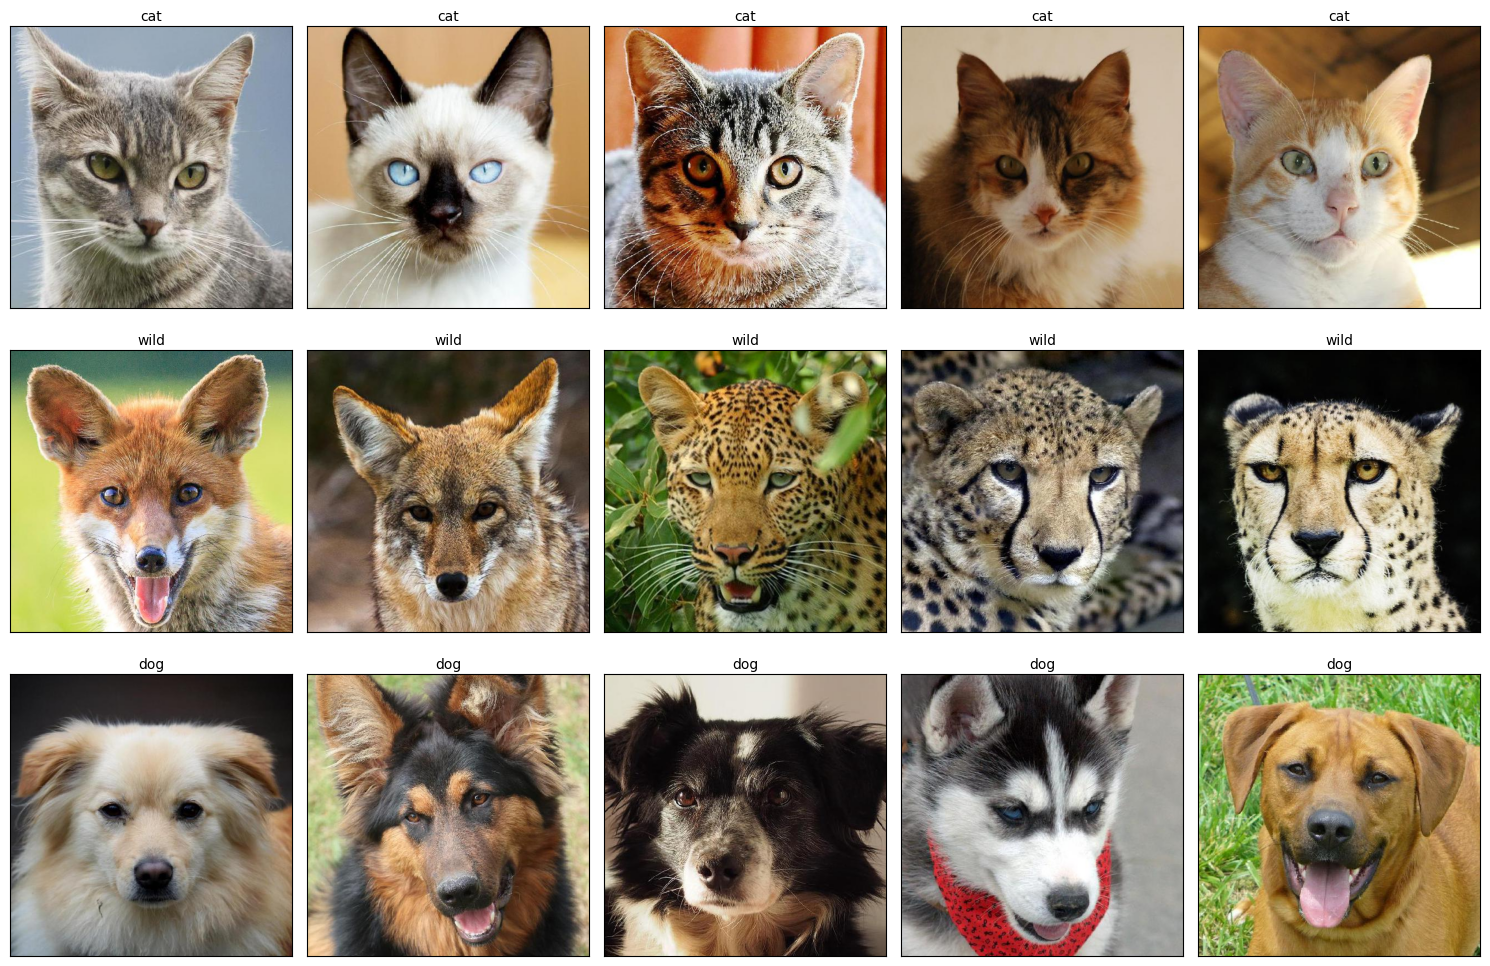

In [11]:
# Visualisasi data
animal_image = {}
path_sub = os.path.join("animal", "dataset")
for category in os.listdir(path_sub):
    category_path = os.path.join(path_sub, category)
    if os.path.isdir(category_path):
        animal_image[category] = os.listdir(category_path)

fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 10))
for i, class_name in enumerate(animal_image.keys()):
    images = np.random.choice(animal_image[class_name], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = plt.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        axs[i, j].xaxis.set_label_position('top')
fig.tight_layout()
plt.show()


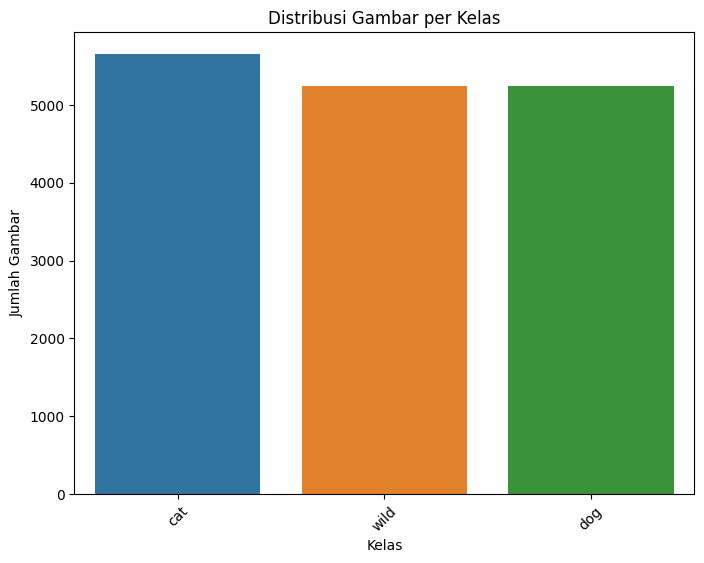

In [12]:
# Distribusi kelas
animal_path = "animal/dataset"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(animal_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

plt.figure(figsize=(8, 6))
sns.countplot(x=distribution_train["labels"])
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

In [13]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(animal_path)) 

In [18]:
df = distribution_train[["path", "labels"]]
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["labels"], random_state=123)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["labels"], random_state=123)

In [19]:
# ImageDataGenerator untuk augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11291 validated image filenames belonging to 3 classes.
Found 2419 validated image filenames belonging to 3 classes.
Found 2420 validated image filenames belonging to 3 classes.


In [20]:
# 2. Bangun Model Sequential dengan Conv2D dan MaxPooling2D
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745383277.513569      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [21]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# 3. Latih Model dengan Callback
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]

In [24]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 153s 425ms/step - accuracy: 0.5930 - loss: 1.4580 - val_accuracy: 0.5511 - val_loss: 2.6445 - learning_rate: 0.0010
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 147s 408ms/step - accuracy: 0.7157 - loss: 0.6791 - val_accuracy: 0.8818 - val_loss: 0.3183 - learning_rate: 0.0010
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 143s 397ms/step - accuracy: 0.7791 - loss: 0.5497 - val_accuracy: 0.6858 - val_loss: 1.2333 - learning_rate: 0.0010
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 146s 405ms/step - accuracy: 0.8071 - loss: 0.4912 - val_accuracy: 0.9091 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 145s 404ms/step - accuracy: 0.8504 - loss: 0.4065 - val_accuracy: 0.9186 - val_loss: 0.2322 - learning_rate: 0.0010
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 145s 403ms/step - accuracy: 0.8774 - loss: 0.3588 - val_accuracy: 0.9363 - val_loss: 0.1718 - learning_rate: 0.0010
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 143s 398ms/step - accura

In [25]:
# 4. Evaluasi Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi Test: {test_accuracy*100:.2f}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9898 - loss: 0.0379
Akurasi Test: 99.01%


76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step


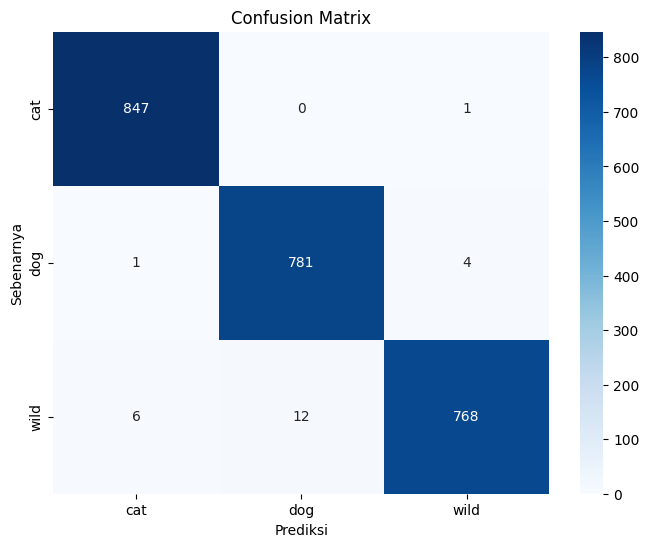

              precision    recall  f1-score   support

         cat       0.99      1.00      1.00       848
         dog       0.98      0.99      0.99       786
        wild       0.99      0.98      0.99       786

    accuracy                           0.99      2420
   macro avg       0.99      0.99      0.99      2420
weighted avg       0.99      0.99      0.99      2420



In [26]:
# Confusion matrix dan classification report
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show()

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

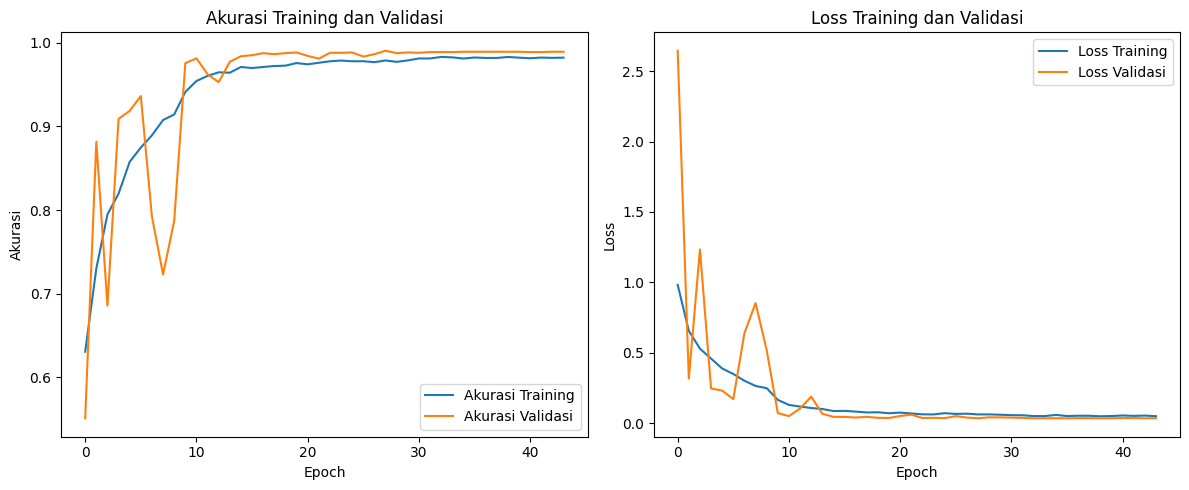

In [27]:
# Plot akurasi dan loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['accuracy'], label='Akurasi Training')
ax1.plot(history.history['val_accuracy'], label='Akurasi Validasi')
ax1.set_title('Akurasi Training dan Validasi')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Akurasi')
ax1.legend()

ax2.plot(history.history['loss'], label='Loss Training')
ax2.plot(history.history['val_loss'], label='Loss Validasi')
ax2.set_title('Loss Training dan Validasi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [30]:
# Simpan model
model.save("animal_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


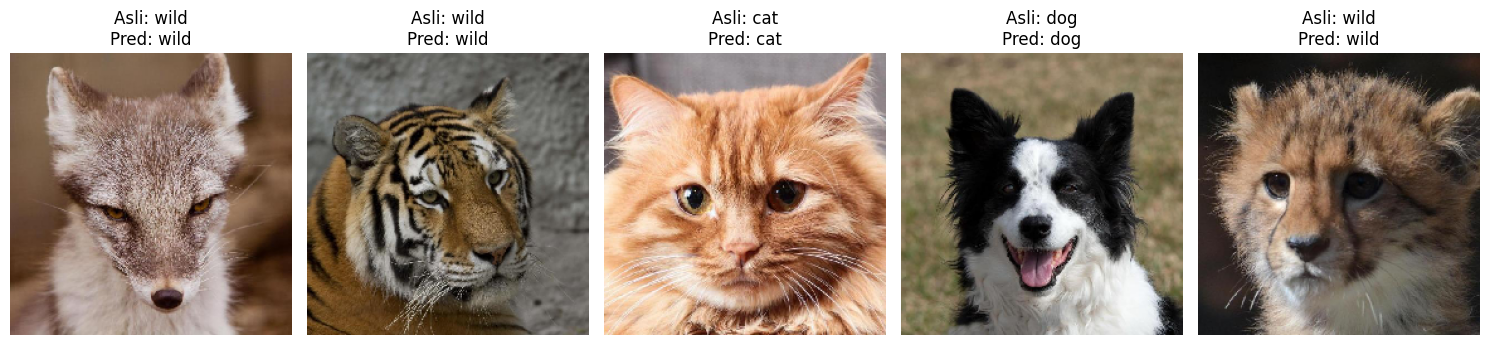

In [53]:
# Load model dari file .keras
model = tf.keras.models.load_model("animal_model.keras")

# Ambil satu batch dari test_generator
for images, labels in test_generator:
    if len(images) < 5:
        random_indices = list(range(len(images)))
    else:
        random_indices = random.sample(range(len(images)), 5)
    break  # Ambil satu batch saja

# Buat figure untuk menampilkan 5 gambar secara horizontal
plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    test_image = images[idx]
    true_label = list(test_generator.class_indices.keys())[np.argmax(labels[idx])]

    test_image_expanded = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image_expanded)
    predicted_class = list(test_generator.class_indices.keys())[np.argmax(prediction[0])]

    # Tampilkan gambar
    plt.subplot(1, 5, i+1)
    plt.imshow(test_image)
    plt.title(f"Asli: {true_label}\nPred: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [55]:
# Buat folder penyimpanan
os.makedirs("submissions/tfjs_model", exist_ok=True)
os.makedirs("submissions/tflite", exist_ok=True)
os.makedirs("submissions/saved_model", exist_ok=True)

# 1. Simpan ke format TensorFlow SavedModel
model.export("submissions/saved_model")

# 2. Simpan ke format TensorFlow.js
tfjs.converters.save_keras_model(model, "submissions/tfjs_model")

# 3. Simpan ke format TFLite
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open("submissions/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label (kelas)
labels = list(test_generator.class_indices.keys())
with open("submissions/tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

Saved artifact at 'submissions/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135087796950544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796952272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796947088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796955536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796946512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796947664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796956496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796957264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796951888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135087796953808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13508779

W0000 00:00:1745398059.203473      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745398059.203514      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [57]:
import shutil

# Buat zip dari folder submissions
shutil.make_archive('/kaggle/working/submissions', 'zip', '/kaggle/working/submissions')

ValueError: unknown archive format '7z'

In [60]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/submissions/saved_model/saved_model.pb')

/kaggle/working/submissions/saved_model/saved_model.pb